In [1]:
# Common imports
import sklearn
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import ensemble
import matplotlib.pyplot as plt

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
# Load dataset from given filepath.

#filepath = "../datasets/AdultDataSet/adult.data"
filepath = "C:/Users/Frederik/Documents/Skole/Machine learning/datasets/AdultDataSet/adult.data"
dataSet = pd.read_table(filepath, sep=",", header=None);

dataSet.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
#Add columns to dataset/ Rename column headers
dataSet = dataSet.rename(columns={0: 'age', 1: 'workclass', 2: 'fnlwgt', 3: 'education', 4: 'education-num',
                                  5: 'marital-status', 6: 'occupation', 7: 'relationship', 8: 'race', 9: 'sex',
                                  10: 'capital-gain', 11: 'capital-loss', 12: 'hours-per-week', 13: 'native-country', 14: 'income'})

In [4]:
# Check info of dataset.
dataSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [5]:
# Function to handle the non-numerical columns in dataset
# Creating function, getting the columns, beginning to iterate through them.
def handle_non_numerical_data(dataSet):
    columns = dataSet.columns.values
    for column in columns:
        text_digit_vals = {}
        # Here, we've added an embedded function that converts,
        # the parameter value to whatever the value of that item (as a key) is from the text_digit_vals dictionary.
        # We aren't using it just yet, but we're about to.
        # Next, while we're iterating through the columns, 
        # we're going to ask if that column is not either an np.int64 or np.float64.
        # If not, then we're going to convert the column to a list of its values, 
        # then we take the set of that column to get just the unique values.
        def convert_to_int(val):
            return text_digit_vals[val]

        if dataSet[column].dtype != np.int64 and dataSet[column].dtype != np.float64:
            column_contents = dataSet[column].values.tolist()
            unique_elements = set(column_contents)
            x = 0
            # Continuing along, for each of the unique elements we find,
            # we create a new dictionary key that is that unique element,
            # with a value of a new number. Once we've iterated through all of the unique values, 
            # we then use mapping to map the function we created before to the pandas column.
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x+=1

            dataSet[column] = list(map(convert_to_int, dataSet[column]))

    return dataSet

In [6]:
# Run function to handle non-numerical data
# Show changes to the dataset
dataSet = handle_non_numerical_data(dataSet)
dataSet.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,1,77516,2,13,3,11,1,4,0,2174,0,40,8,0
1,50,2,83311,2,13,1,8,5,4,0,0,0,13,8,0
2,38,0,215646,10,9,4,5,1,4,0,0,0,40,8,0
3,53,0,234721,6,7,1,5,5,2,0,0,0,40,8,0
4,28,0,338409,2,13,1,1,4,2,1,0,0,40,40,0


In [7]:
# Compute pairwise correlation of columns, excluding NA/null values.
corr_matrix = dataSet.corr()
corr_matrix["income"].sort_values(ascending=False)

income            1.000000
relationship      0.403046
education-num     0.335154
age               0.234037
hours-per-week    0.229689
capital-gain      0.223329
capital-loss      0.150526
race              0.061194
workclass         0.037793
fnlwgt           -0.009463
occupation       -0.015526
native-country   -0.051459
education        -0.133080
sex              -0.215980
marital-status   -0.350305
Name: income, dtype: float64

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

# Do not touch the target attribute
targetAttribute = ["income"]

# Standardize all the feature attributes
scaledAttributes = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country"]

fullPipeline = ColumnTransformer([
    ("target", 'passthrough', targetAttribute),  
    ("scaled", StandardScaler(), scaledAttributes)
    #("onehot", OneHotEncoder(sparse_output=False), originAttribute)
])

dataPrepared = fullPipeline.fit_transform(dataSet)

dataPrepared

array([[ 0.        ,  0.03067056, -0.04996232, ..., -0.21665953,
        -0.03542945, -0.25887519],
       [ 0.        ,  0.83710898,  0.44301435, ..., -0.21665953,
        -2.22215312, -0.25887519],
       [ 0.        , -0.04264203, -0.54293899, ..., -0.21665953,
        -0.03542945, -0.25887519],
       ...,
       [ 0.        ,  1.42360965, -0.54293899, ..., -0.21665953,
        -0.03542945, -0.25887519],
       [ 0.        , -1.21564337, -0.54293899, ..., -0.21665953,
        -1.65522476, -0.25887519],
       [ 1.        ,  0.98373415,  1.42896769, ..., -0.21665953,
        -0.03542945, -0.25887519]])

In [9]:
dataPrepared.shape

(32561, 15)

In [10]:
# use the first 4 columns in dataset.
X = dataPrepared[:,0:3]
y = dataPrepared[:,3]

In [11]:
#Split the dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=45)

# Gradient Boosting with Early stopping
In order to find the optimal number of trees, i make use of early stopping.

In [12]:
# Train a GradientBoostingRegressor:
gbrt = GradientBoostingRegressor(max_depth=4, n_estimators=500, random_state=42)
gbrt.fit(X_train, y_train)

# Measure the validation error at each stage of training to find the optimal number of trees.
# The staged_predict() returns an iterator over the predictions made by the ensemble at each iteration of training.

errors = [mean_squared_error(y_test, y_pred) for y_pred in gbrt.staged_predict(X_test)]

bst_n_estimators = np.argmin(errors) + 1

In [13]:
# Train another GradientBoostingRegressor using the optimal number of trees:
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=16, random_state=42)

In [14]:
# Calculate MSE on Training set
mse = mean_squared_error(y_train, gbrt_best.predict(X_train))
print("The mean squared error (MSE) on train set: {:.4f}".format(mse))

The mean squared error (MSE) on train set: 1.0023


In [15]:
# Calculate MSE on Test set
mse = mean_squared_error(y_test, gbrt_best.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 0.9639


# Showing Deviance in a graph

C:\Users\Frederik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)


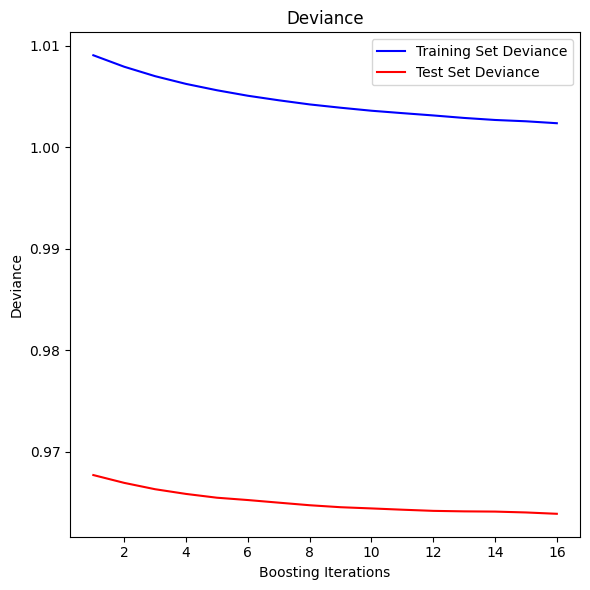

In [17]:
test_score = np.zeros((bst_n_estimators), dtype=np.float64)
for i, y_pred in enumerate(gbrt_best.staged_predict(X_test)):
    test_score[i] = gbrt_best.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(bst_n_estimators) + 1,
    gbrt_best.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(bst_n_estimators) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()